# Roman Egyptian parameters for demographic simulation #

Using the households ABM, it is possible to simulate more specific socieites using detailed sociohistorical and demographic reconstructions. All citations from Bagnall and Frier unless otherwise specified.

The villages have an average population between 1000 to 1500 people (range 100-4000), while the metropoleis have about 25,000 residents (55-56). A single nome seems to contain 40-60 villages and one metropolis on average. Metropoleis have substantially more nuclear and small families than the complex families of the villages (67, fig. 3.2.) Housing prices in metropoleis make larger families harder to maintain in metropoleis (70), and wealth is concentrated in those settlements (70 ftnt 65, ch 2 ftnt 58). 

There is no long-term population growth, with a growth rate around .1% annually (81) or .2% based on the estimates of female life expectancy (87). The female birth rate is 42-54 per thousand and the mortality rate West 2 (90), while the male mortality rate is probably Level 3 or Level 4, with level 3 more likely (108 ftnt 49). Fertility exists age 12 to 50, and women who live to age 15 give birth to an average of 5.979 children, with a sex ratio of 105 men to 100 women (139)


### Calibration data

167 census returns provide evidence for the Laslett typology classification of the house, while an additional 36 are uninhabited but taxable property (58). Solitary marriages are largely the survivors of families who didn't marry or outlived everyone else (60). Nuclear households are the plurality (61), favored by attrition rather than neolocality (61). (Note: they count families as nuclear even if one spouse dies!) (61). 

Table 3.1: 16.2, 4.8, 43.1, 15.0, 21.0 (overall averages)
Table 3.2: Metropoleis: 16.7, 5.6, 51.4, 11.1, 15.3
            Villages: 15.8, 4.2, 36.8, 17.9, 25.3
Table 4.1: female age distribution (living)
Table 5.x: male age distribution (living)



We start by loading the households package:

In [1]:
import os
os.chdir('..')
from households import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd


Importing the households package
Importing identity
importing kinship
importing residency
importing behavior
loading narrative
Importing main.py
importing inheritance
importing marriage
importing mobility


(You'll only ever need to run this next line if you've made changes to the code and are needing to reload the package.)

In [2]:
#Bagnall and Frier estimates: note Male West 4 should really be West 3 based on their footnotes, even if the main
## text argues for West 4.
maledeath = pd.read_csv('../data/demo/West4Male.csv')
ages = list(maledeath.Age1) + [list(maledeath.Age2)[-1]]
malerates = list(maledeath[maledeath.columns[2]])
femaledeath = pd.read_csv('../data/demo/West2Female.csv')
femalerates = list(femaledeath[femaledeath.columns[2]])
mortality = AgeTable(ages = ages, sex1 = identity.male, rates1 = malerates, sex2 = identity.female, rates2 = femalerates )

In [26]:
#Bagnall and Frier, table 7.1, model reconstructed fertility rates
fertility = AgeTable(ages = [0,12,15,20,25,30,35,40,49,100], sex1 = female, rates1 = [0,.0229,.1397,.2609,.2751,.2384,.1779,.0851,.01200], sex2 = male, rates2 = [0,0,0,0,0,0,0,0,0,0]) 
#marital fertility rate: 70 % of hutterite (144-145)
hutterite = [0,.3,.55,.5020,.4470, .4060, .2220, .0610, 0]
#hutteriteages = [0,12,15,20,25,30,35,40,49,100]
#hutteriteannual = [1. - (1-.7*r)**(1./(hutteriteages[i+1]-hutteriteages[i])) for r, i in zip(hutterite,range(len(hutterite)))]
maritalfertility = AgeTable(ages = [0,12,15,20,25,30,35,40,49,100], sex1 = female, rates1 = [.6*r for r in hutterite], sex2 = male, rates2 = [0,0,0,0,0,0,0,0,0,0]) 
#unmarriedfertility = AgeTable(ages = [0,12,15,20,25,30,35,40,49,100], sex1 = female, rates1 = [r*.175 for r in hutterite], sex2 = male, rates2 = [0,0,0,0,0,0,0,0,0,0]) 

## Scheduling life events ##



In [27]:
age_of_majority = 15
eligibility = AgeTable(ages = [0,15,100], sex1 = female, rates1 = [0,.75], sex2 = male, rates2 = [0,.75])

remarriage = AgeTable.NullAgeTable()



The three rules that we have to define are, at present, a `MarriageRule`, a `MobilityRule`, and an `InheritanceRule`. We treat these each in turn.


### `BirthRule`: 



### `MarriageRule`: 



### `MobilityRule`: 



### `InheritanceRule`: 





In [28]:
birthrule = behavior.conception.BirthRule(marriedbirth = maritalfertility,
                                         unmarriedbirth = AgeTable.NullAgeTable(), #unmarriedfertility,
                                         femalesexratio = .4878,
                                         maternaldeath = behavior.conception.maternal_death_zero,
                                         infanticide = behavior.conception.infanticide_none)

#The MarriageRule
marriagerule = behavior.marriage.MarriageRule(eligibility_agetable = eligibility, #defined above
                                              get_eligible = behavior.marriage.get_eligible_not_sibling_same_community,
                                              #find all single individuals in the village who aren't siblings
                                              pick_spouse = behavior.marriage.pick_spouse_random, #pick a random spouse
                                              locality = behavior.marriage.locality_patrilocality, #patrilocality
                                              remarriage_agetable = remarriage #defined above
                                             )

#The MobilityRule
def check_household_nonowner_adult_man_overcrowded(person):
    """Check that the household is overcrowded and that this person is not the owner and an adult."""
    overcrowded = behavior.mobility.check_household_overcrowded(person) #check overcrowding but also assert
    ## that there is indeed a house to check
    if overcrowded:
        if person.age >= age_of_majority and person not in person.has_house.get_owners() and person.sex == identity.male:
            #If above or at the age of majority and the person is a man who is not the owner of the house they live in
            if rd.random() < .1: #make this process somewhat random
                return True
    return False

mobilityrule = behavior.mobility.MobilityRule(check_household = check_household_nonowner_adult_man_overcrowded,
                                                   who_leaves_house = behavior.mobility.who_leaves_house_family,
                                                   destination = behavior.mobility.destination_random_house_same_village)

#The InheritanceRule
#Our custom function to check sons then brothers' sons;
## note the use of lambda to make find_heirs_siblings_children into a single parameter function in order to define
## the sex as male.
find_heirs_sons_then_brothers_sons = behavior.inheritance.find_heirs_multiple_constructor(behavior.inheritance.find_heirs_sons_oldest_to_youngest,
                                                     lambda p: behavior.inheritance.find_heirs_siblings_children_oldest_to_youngest(p,sex = identity.male))


inheritancerule = behavior.inheritance.InheritanceRuleComplex(has_property = behavior.inheritance.has_property_houses,
                                                                    find_heirs = find_heirs_sons_then_brothers_sons,
                                                                    limit_heirs = behavior.inheritance.limit_heirs_not_owners,
                                                                    distribute_property = behavior.inheritance.distribute_property_to_first_heir_and_move_household,
                                                                    failure = behavior.inheritance.failed_inheritance_no_owner)



With all of these functions defined, we can now create the `World` of the simulation and our sole `Community`, Sweetwater.

In [29]:
start_pop = 300 #just a few people to start
start_area = 1000 #lots of room for growth
start_age = age_of_majority - 1 #so that everyone makes the transition to marriage eligibility on time

rd.seed(1237) #Used here to standardize the example code across runs for any random parts like name generation.
terra = World()
sweetwater = Community(world = terra,
                       name = 'Sweetwater',
                       pop = start_pop,
                       area = start_area,
                       startage = start_age,
                       mortab = mortality,
                       birthtab = fertility,
                       marriagerule = marriagerule,
                       inheritancerule = inheritancerule,
                       mobilityrule = mobilityrule,
                       birthrule = birthrule)


rd.seed(123) #important to standardize after setup, just in case
pophistory = []

And there we have it! The hard work is setting up the functions; making the world and defining communities is easy. We can now run the simulation.

In [30]:
while terra.year < 150: #run for 149 years
    terra.progress()
    pophistory.append(len(terra.people))
    
print(terra.year)

150


In [31]:
len(terra.people)

460

We can now generate some figures to see what's been going on. For instance, let's see what birthyears are recorded in Diaries of individuals.

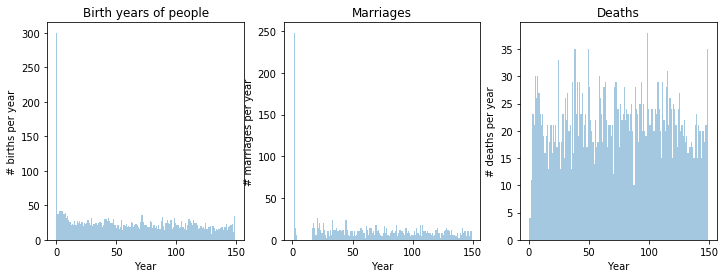

In [32]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))
#sns.set_style("whitegrid")
sns.distplot([min(d.get_events().keys()) for d in terra.library['Person']], kde = False, bins = range(terra.year), ax = ax1)
ax1.set_title("Birth years of people")
#plt.subtitle("Third generation is normally distributed.")
ax1.set_xlabel("Year")
ax1.set_ylabel("# births per year")

sns.distplot([l.year for i in range(len(terra.library['Person'])) for x in terra.library['Person'][i].get_events().items() for l in x[1] if isinstance(l,narrative.MarriageEvent)]
             , kde = False, bins = range(terra.year), ax = ax2)
ax2.set_title("Marriages")
#ax2.subtitle("Third generation is normally distributed.")
ax2.set_xlabel("Year")
ax2.set_ylabel("# marriages per year")

sns.distplot([l.year for i in range(len(terra.library['Person'])) for x in terra.library['Person'][i].get_events().items() for l in x[1] if isinstance(l,narrative.DeathEvent)],
             kde = False, bins = range(terra.year), ax = ax3)
ax3.set_title("Deaths")
#ax2.subtitle("Third generation is normally distributed.")
ax3.set_xlabel("Year")
ax3.set_ylabel("# deaths per year")


print('')
#plt.hist([min(d.get_events().keys()) for d in terra.library['Person']], bins = range(45))

We can also look at the different ways people are living in houses, for example how many nuclear families live in each house.

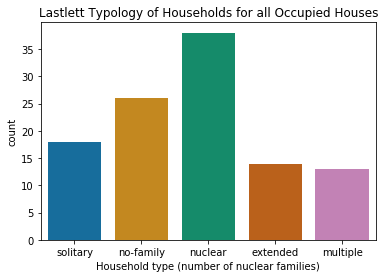

In [33]:
sns.countplot([residency.classify(h) for h in terra.houses if h.people != []], order = ['solitary','no-family','nuclear','extended','multiple'], palette = 'colorblind')
plt.title('Lastlett Typology of Households for all Occupied Houses')
plt.xlabel('Household type (number of nuclear families)')
print('')

Text(0.5, 1.0, 'Population through time')

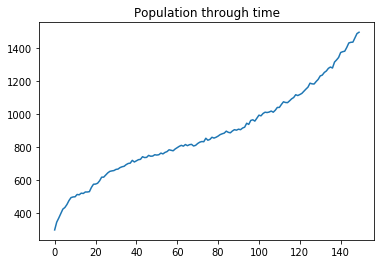

In [11]:
sns.lineplot(range(terra.year),pophistory)
plt.title('Population through time')

In addition to viewing the entire world, we can also use the tools in narrative to explore single individuals and their households.

In [12]:
#Run this first to pick a random house
h = rd.choice([x for x in sweetwater.houses if len(x.people) >= 2])#pick a house with at least two people in it to make it interesting

In [13]:
#Now run this to see the output
print('The house at ' + h.address + ' contains ' + narrative.census(h)+':')
for x in h.people:
    print(narrative.biography(x)) 
print(' ')


The house at 61 Cactus Court contains a no-family household with 2 people residing owned by Hector (1.0 shares):
Clementine is a living woman, 35 years old, widowed with 4 children
Hector is a living man, 9 years old, ineligible
 


In [14]:
#Here is some space to explore the currently selected household, if you want.

strange = [h for h in terra.houses if len([p for p in h.people if p in h.get_owners()]) == 0 and len(h.people) > 0]
i = 0
print(strange[i].address + ': ' + narrative.census( strange[i]))
o = strange[i].get_owners()[0]
print(narrative.biography(o))
#who lives there?
for p in strange[i].people:
    print(narrative.biography(p))
    print(p in kinship.get_siblings(o))
    print(p in kinship.get_children(o))


65 Other Street: a multiple household with 8 people residing with no owner


IndexError: list index out of range

In [ ]:
f = [p for p in kinship.get_parents(o) if p.sex == identity.male][0]

print([e.summary() for l in o.diary.get_events().items() for e in l[1] if e.house is not None]) # 


This provides the tools you need to implement and see some results of a simulation. 

The sections below provide some debugging tools.

In [ ]:
#Look up a single person based on memory
p = [p for p in sweetwater.people if str(p) == '<households.main.Person object at 0x00000244063379C8>'][0]
#behavior.mobility.check_household_overcrowded(p)
#behavior.mobility.destination_random_house_same_village(None, [p])
narrative.biography(p)
narrative.census(p.has_house)
for q in kinship.get_parents(p):
    print(narrative.biography(q))
    if q.has_house != None: print(narrative.census(q.has_house))

Let's simulate multiple seeds to check settings:

In [ ]:
start_pop = 300 #just a few people to start
start_area = 1000 #lots of room for growth
start_age = age_of_majority - 1 #so that everyone makes the transition to marriage eligibility on time

rd.seed(505)
seeds = [rd.randint(1,10000) for i in range(10)]
pophistories = []
years = 100

for seed in seeds:
    print('seed ' + str(seed) + ' started')
    rd.seed(seed) #Used here to standardize the example code across runs for any random parts like name generation.
    terra = World()
    sweetwater = Community(world = terra,
                           name = 'Sweetwater',
                           pop = start_pop,
                           area = start_area,
                           startage = start_age,
                           mortab = mortality,
                           birthtab = fertility,
                           marriagerule = marriagerule,
                           inheritancerule = inheritancerule,
                           mobilityrule = mobilityrule,
                           birthrule = birthrule)


     #important to standardize after setup, just in case
    pophistory = []
    while terra.year < years: 
        terra.progress()
        pophistory.append(len(terra.people))
    pophistories.append(pophistory)
    print('seed ' + str(seed) + ' completed')

In [ ]:
for p in pophistories:
    sns.lineplot(range(terra.year),p)
plt.title('Population through time for different seeds')